# Density simulation of the Burgers equation 

This notebook implements the simulations described in Section 3.3 of 

- Hoffmann, M. and Liu, Y (2023). A statistical approach for simulating the density solution of a McKean-Vlasov equation. 

-------------------------------

**Contents**

* [1. Definition of the Burgers equation, the particle system and the Euler scheme](#chapter1)

* [2. Density simulation with Gaussian-based high order Kernels](#chapter2)

    * [2.1 Definition of Gaussian-based high order Kernels](#section2-1)
    
    * [2.2 Data-driven bandwidth selection](#section2-2)
    
    * [2.3 Gaussian Kernel ( Kernel Order = 1 )](#section2-3)
    
    * [2.4 Kernel Order = 3](#section2-4)
    
    * [2.5 Kernel Order = 5](#section2-5)
    
    * [2.6 Kernel Order = 7](#section2-6)
    
    * [2.7 Kernel Order = 9](#section2-7)
    
    * [2.8 Comparison of simulated densities with different kernels](#section2-8)

-------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import pandas as pd 
from scipy.stats import norm
from scipy import integrate
from scipy import special # special.erfc(x) for the function erfc
from scipy.integrate import quad
import math
from sklearn.linear_model import LinearRegression

#import time as time
#import copy as copy

## 1. Definition of the Burgers equation, the particle system and the Euler scheme<a class="anchor" id="chapter1"></a> 




We consider the Burgers equation as described in  

* Bossy, M., & Talay, D. (1997). A stochastic particle method for the McKean-Vlasov and the Burgers equation. Mathematics of computation, 66(217), 157-192.


The definition of the Burgers equation is 

$$dX_t = \Big[\int_{\mathbb{R}}b(X_t,y)\mu_t(dy)\Big]dt+\sigma \, dB_t\qquad (1)$$

with $b(x,y)=H(x-y)=\mathbb{1}_{x\geq y}$. 


If $X_0=0$, the cumulative distribution function $V(t,x)$ of $X_t$ is (see [Bossy-Talay-97] and [Hopf 1950])

$$ V(t,x)= \frac{\int_{0}^{+\infty}\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}+y\Big]\Big)dy}{\int_{-\infty}^{0}\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}\Big]\Big)dy+\int_{0}^{+\infty}\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}+y\Big]\Big)dy}\qquad (2)$$


- We take $\sigma=\sqrt{0.2}$ as Table 1 of [Bossy-Talay 97]. 


In [2]:
sigma=np.sqrt(0.2)

The next cell computes the true cumulative distribution function.

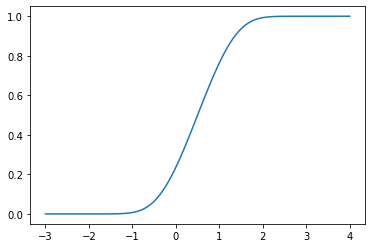

In [3]:
# Compute the true cumulative distribution function

integrand = lambda y,x,t: np.exp((-1/sigma**2.0)*((x-y)**2/(2*t)+y)) # la function l
integrand2 = lambda y,x,t: np.exp((-1/sigma**2.0)*((x-y)**2/(2*t)))  # la function g

def H(t,x):
    return quad(integrand, 0, np.inf, args=(x,t))[0]

def B(t,x):
    return quad(integrand2, -np.inf, 0, args=(x,t))[0]+H(t,x)

def V(t,x):
    return H(t,x)/B(t,x)

def cdf_true(X):   # calculate the true value of true cdf
    cdf=np.zeros(X.size)
    for i in range(X.size):
        cdf[i]=V(1,X[i])
    return cdf

# test the true distribution function 

xx=np.linspace(-3,4,100)

yy=cdf_true(xx)
plt.plot(xx,yy)

plt.savefig('Burgers_true_cdf.png')


From (2), the true density function can be computed as follows. 

Let 

$$H(t,x)=\int_{0}^{+\infty}\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}+y\Big]\Big)dy$$

and let 

$$B(t,x)=\int_{-\infty}^{0}\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}\Big]\Big)dy+H(t,x)。$$

It is obvious that $V(t,x)= \frac{H(t,x)}{B(t, x)}$. 

Moreover, let 

$$l(t,x,y)=\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}+y\Big]\Big),$$

then 

$$\partial_x l(t,x,y)=-\frac{(x-y)}{\sigma^2t}\exp\Big(-\frac{1}{\sigma^2}\big[\frac{(x-y)^2}{2t}+y\big]\Big)$$

(denoted by `dl` in the next cell) and 

$$\partial_x H(t,x)=\int_{0}^{+\infty}\partial_x l(t,x,y) dy$$

(denoted by `dH` in the next cell). 

Furthermore, let 

$$g(t,x,y)=\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}\Big]\Big),$$

then 

$$\partial_x g(t,x,y)=-\exp\Big(-\frac{1}{\sigma^2}\Big[\frac{(x-y)^2}{2t}\Big]\Big)\cdot \frac{x-y}{\sigma^2 t}$$

(denoted by `dg` in the next cell) and

$$\partial_x B(t,x)= \int_{-\infty}^{0} \partial_x g(t,x,y) dy + \partial_x H(t,x)$$

(denoted by `dB` in the next cell). 

Finaly, let $u(t,x)$ denotes the density function $\mu_t(x)$, we have 

$$u(t,x)=\partial_x V(t,x)=\frac{1}{B(t,x)^2}\Big[B(t,x)\partial_x H(t,x)-H(t,x)\partial_x B(t,x)\Big].$$


The next cell computes the true density function $u(t,x)$.

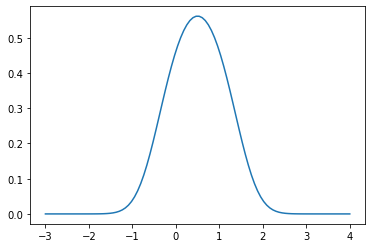

In [4]:
# Compute the true density function

dl = lambda y,x,t: -((x-y)/(sigma**2.0*t))*np.exp((-1/sigma**2.0)*((x-y)**2/(2*t)+y))

def dH(t,x):
    return quad(dl, 0, np.inf, args=(x,t))[0]

dg = lambda y,x,t: -((x-y)/(sigma**2.0*t))*np.exp((-1/sigma**2.0)*((x-y)**2/(2*t)))

def dB(t,x):
    return quad(dg, -np.inf, 0, args=(x,t))[0]+dH(t,x)

def u(t,x):
    return (B(t,x)*dH(t,x)-H(t,x)*dB(t,x))/(B(t,x)**2)


def density_true(X):   # calculate the true value of true density function 
    den=np.zeros(X.size)
    for i in range(X.size):
        den[i]=u(1,X[i])
    return den

# test the true density function 

xx2=np.linspace(-3,4,100)

yy2=density_true(xx2)
plt.plot(xx2,yy2)

plt.savefig('Burgers_true_density.png')


Let $N$ be the number of particles. Let $M$ denote the time discretization number for the Euler scheme. Set $h=\frac{T}{M}$ and $t_m=m\cdot h, 0\leq m\leq M$. Combining the particle system and the Euler scheme, we obtain the discrete particle system is defined by  :
 
 $$\bar{X}^{n,h}_{t_{m+1}}=\bar{X}^{n,h}_{t_{m}} + h\cdot \frac{1}{N}\sum_{j=1}^{N}H(\bar{X}^{n,h}_{t_{m}}-\bar{X}^{j,h}_{t_{m}}) +\sqrt{h}\cdot \sigma Z_{m+1}\qquad 1\leq n\leq N,$$

where $ \: Z_{m+1}^{n}:=\frac{1}{\sqrt{h}}(B^n_{t_{m+1}}-B^n_{t_{m}})$ are i.i.d random variables having the standard normal distribution $\mathcal{N}(0,1)$.


In [5]:

def Euler_one_step(X_in,N_in):
    X_out=np.zeros(N_in)
    for n in range(N_in):
        aa=X_in[n]-X_in
        X_out[n]=X_in[n]+h*np.heaviside(aa,1).sum()/N_in+np.sqrt(h)*sigma*np.random.normal(0, 1, 1)
    return X_out



Now we compute the particle systems for $T=1$, $M=$ with $2^5,2^6,...,2^{16}$ particles.

We save the repective particle in "burger_eq_particle_number_N.csv" with $N\in\{2^5,2^6,...,2^{16}\}$

In [6]:
pn=12
N_power=np.linspace(5,16,pn) 

print (N_power)
N_vec=np.zeros(pn)
N_vec=2**N_power.astype(int) # Number of particles, from 2^5 to 2^16
print (N_vec)



[ 5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]
[   32    64   128   256   512  1024  2048  4096  8192 16384 32768 65536]


In [7]:
# Time discretization parameters

T=1. 
M=100  # Time discretization number
h=T/M  # Time step

In [8]:
for i in tqdm(range(pn)):
    particle_process=np.zeros((N_vec[i],M))
    for m in range(M-1):
        particle_process[:,m+1]=Euler_one_step(particle_process[:,m],N_vec[i])
    
    np.savetxt("burger_eq_particle_number_"+str(N_vec[i])+".csv", particle_process[:,-1], delimiter=",")


100%|████████████████████████████████████████| 12/12 [3:08:46<00:00, 943.84s/it]


-------------------

# 2. Density simulation with Gaussian-based high order Kernel <a class="anchor" id="chapter2"></a> 

## 2.1 Definition of Gaussian-based high order kernel <a class="anchor" id="section2-1"></a> 



The Gaussian-based high order kernels that we use in this notebook are 
- Order 1 : $\phi(x)=\frac{1}{\sqrt{2\pi}}\exp\big(-\frac{x^2}{2}\big)$



- Order 3 : $\frac{1}{2}(3-x^2)\,\phi(x)$



- Order 5 : $\frac{1}{8}(15-10x^2+x^4)\,\phi(x)$



- Order 7 : $\frac{1}{48}(105-105x^2+21x^4-x^6)\,\phi(x)$



- Order 9 : $\frac{1}{384}(945-1260x^2+378x^4-36x^6+x^8)\,\phi(x)$


which are defined in the following paper (see Table 1):

- Wand, Matthew P., and William R. Schucany. "Gaussian‐based kernels." Canadian Journal of Statistics 18, no. 3 (1990): 197-204.



In [8]:
# Kernel order 1

def kernel_O1(x_in):
    return np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O1_fun = lambda x: np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 3

def kernel_O3(x_in):
    return 0.5*(3-x_in**2)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)

kernel_O3_fun = lambda x: 0.5*(3-x**2)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)

# Kernel order 5

def kernel_O5(x_in):
    return (15-10*x_in**2+x_in**4)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/8

kernel_O5_fun = lambda x: (15-10*x**2+x**4)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/8

# Kernel order 7

def kernel_O7(x_in):
    return (105-105*x_in**2+21*x_in**4-x_in**6)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/48

kernel_O7_fun = lambda x: (105-105*x**2+21*x**4-x**6)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/48

# Kernel order 9

def kernel_O9(x_in):
    return (945-1260*x_in**2+378*x_in**4-36*x_in**6+x_in**8)*np.exp(-0.5*(x_in**2))/np.sqrt(2*np.pi)/384

kernel_O9_fun = lambda x: (945-1260*x**2+378*x**4-36*x**6+x**8)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/384


The next cell shows the curves of different kernels.

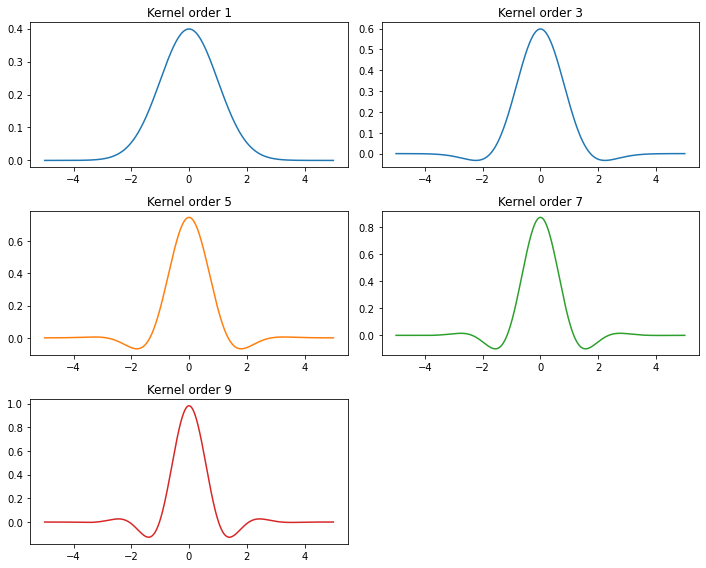

In [9]:
test_xx=np.linspace(-5,5,1000)
Kernel_O1_plot=kernel_O1_fun(test_xx)
Kernel_O3_plot=kernel_O3_fun(test_xx)
Kernel_O5_plot=kernel_O5_fun(test_xx)
Kernel_O7_plot=kernel_O7_fun(test_xx)
Kernel_O9_plot=kernel_O9_fun(test_xx)


fig, axs = plt.subplots(3, 2, figsize=(10,8))
axs[0, 0].plot(test_xx, Kernel_O1_plot)
axs[0, 0].set_title('Kernel order 1')
axs[0, 1].plot(test_xx, Kernel_O3_plot)
axs[0, 1].set_title('Kernel order 3')
axs[1, 0].plot(test_xx, Kernel_O5_plot, 'tab:orange')
axs[1, 0].set_title('Kernel order 5')
axs[1, 1].plot(test_xx, Kernel_O7_plot, 'tab:green')
axs[1, 1].set_title('Kernel order 7')
axs[2, 0].plot(test_xx, Kernel_O9_plot, 'tab:red')
axs[2, 0].set_title('Kernel order 9')
axs[2, 1].axis('off')
fig.tight_layout()

plt.savefig('gaussian_high_order_kernel.png')

The next cell computes the $L^2-$norm of different kernels $|K|_{L^2}=(\int_{\mathbb{R}}|x|^2dx)^{1/2}$. 

In [10]:
# Kernel order 1

kernel_O1_fun_square = lambda x: (np.exp(-0.5*(x**2))/np.sqrt(2*np.pi))**2

normL2_O1 = integrate.quad(kernel_O1_fun_square, -np.inf, np.inf)[0]
print (normL2_O1)

# Kernel order 3

kernel_O3_fun_square = lambda x: (0.5*(3-x**2)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi))**2

normL2_O3 = integrate.quad(kernel_O3_fun_square, -np.inf, np.inf)[0]
print (normL2_O3)

# Kernel order 5

kernel_O5_fun_square = lambda x: ((15-10*x**2+x**4)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/8)**2

normL2_O5 = integrate.quad(kernel_O5_fun_square, -np.inf, np.inf)[0]
print (normL2_O5)

# Kernel order 7

kernel_O7_fun_square = lambda x: ((105-105*x**2+21*x**4-x**6)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/48)**2

normL2_O7 = integrate.quad(kernel_O7_fun_square, -np.inf, np.inf)[0]
print (normL2_O7)

# Kernel order 9

kernel_O9_fun_square = lambda x: ((945-1260*x**2+378*x**4-36*x**6+x**8)*np.exp(-0.5*(x**2))/np.sqrt(2*np.pi)/384)**2

normL2_O9 = integrate.quad(kernel_O9_fun_square, -np.inf, np.inf)[0]
print (normL2_O9)

0.28209479177387786
0.47603496111841886
0.623969436882652
0.7478507861754393
0.8564800110622434


## 2.2 Data-driven bandwidth selection <a class="anchor" id="section2-2"></a> 

The following cells implement the data-driven bandwidth selection strategies, as described in Theorem 2.12 and Corollary 2.13 of [Hoffmann, M. and Liu, Y (2023)]. 


The function `H_set_func` compute the bandwidth set $\mathcal{H}$ defined in Corollary 2.13, i.e.

$$\mathcal{H}=\Big\{\; \big(\frac{N}{\log N}\big)^{-\frac{1}{2m+d}} ,\; m=1, ..., l+1\;\Big\},$$

where $l$ denotes the order of the kernel. The output of the function `H_set_func` is ordered increasingly. 



In [11]:
def H_set_func(N_in,l_regularity_plus_one):
    h_value=np.zeros(l_regularity_plus_one)
    for i in range(l_regularity_plus_one):
        ind=-1./(2*(i+1)+1)
        h_value[i]=(N_in/np.log(N_in))**ind
    h_order=np.sort(h_value)
    return h_order

For the particle system $(\bar{X}_{T}^{1,h}, ..., \bar{X}_{T}^{N,h})$ at time T, for every bandwidth $\eta$ in the bandwidth set $\mathcal{H}$, and for the fixed input kernel $K$, the output of the function `KDE_fun_s` in the next cell are simulated density functions defined in Section 2.2 : 


$$\Big\{\; x\mapsto \widehat{\mu}_T^{N, h, \eta}(x):= \frac{1}{N}\sum_{n=1}^{N}\eta^{-d}K\big(\eta^{-1}(x-\bar{X}_T^{n,h})\big),\quad  \eta \in \mathcal{H}\;\Big\}.$$


In [12]:
# The following function is the density estimation function with a fixed input kernel
# Input : the bandwidth_s in H_set, the kernel base K(x), the particles and the particle numbers.
# Output : the density estimation functions with reprectives bandwidths in H_set

def KDE_fun_s(particle_num_in, particle_in, kernel_base_fun_in, H_set_in):
    KDE_output=[]
    for i in range(H_set_in.size):
        eta_parameter=H_set_in[i]
        def funcC(parameter):
            def func(x_in):
                return kernel_base_fun_in((x_in-particle_in)/parameter).sum()/(particle_num_in*parameter)
            return func
        KDE_output.append(funcC(eta_parameter))
    return KDE_output



In the next cell, the function `V_value` computes $V_\eta^N$ defined in (14), i.e. 

$$V_\eta^N=\bar{w}|K|_{L^2}^2(\log N)N^{-1}\eta^{-d},$$

where $\bar{w}$ is a pre-factor, $K$ is the kernel, $N$ is the particle number and $\eta$ is the bandwidth.

In [13]:
# We compute the value of V_eta^N, which depends on the pre-factor w_bar

def V_value(eta_in, N_in, kernel_norm_square_in):
    return w_bar*kernel_norm_square_in*np.log(N_in)/(N_in*eta_in)



In the next cell, the function `A_value` computes $A_{\eta}^{N}(T=1,x)$ for given $x\in\mathbb{R}$ with respect to the following formula 

$$A_{\eta}^{N}(t,x)=\max_{\eta'\leq \eta, \eta'\in\mathcal{H}}\Big\{ \;\big(\widehat{\mu}_{t}^{N, h, \eta}(x)-\widehat{\mu}_{t}^{N, h, \eta'}(x)\big)^2-(V_{\eta}^N+V_{\eta'}^{N})\Big\}_{+},$$

where $\{x\}_{+}=\max(x,0)$, $\mathcal{H}$ is an input bandwidth set, $V_{\eta}^{N}$ is defined in the previous cell and $\widehat{\mu}_T^{N, h, \eta}(x):= \frac{1}{N}\sum_{n=1}^{N}\eta^{-d}K\big(\eta^{-1}(x-\bar{X}_T^{n,h})\big)$ is the simulated density function. 

In [14]:
def A_value(particle_num_in, KDE_fun_s_in, H_set_in, kernel_norm_square_in, eta_in, x_in):
    A_vector=[]
    index=np.where(H_set_in==eta_in)[0][0]
    if index == 0:
        print ("Attention ! A_value(eta_0)==0, no need compute ! ")
    for i in range(index):
        append_in_part1=(KDE_fun_s_in[index](x_in)-KDE_fun_s_in[i](x_in))**2
        append_in_part2=V_value(eta_in, particle_num_in, kernel_norm_square_in)+V_value(H_set_in[i], particle_num_in, kernel_norm_square_in)
        A_vector.append(max(append_in_part1-append_in_part2,0))
    return max(A_vector)


The following cell gives the optimal choice of the bandwidth (formula (15) in the paper)

$$\widehat{\eta}^{N}(T=1,x)\in\text{argmin}_{\eta\in\mathcal{H}}\big( A_{\eta}^{N}(T=1, x)+V_{\eta}^{N}\big)\;. $$

In [15]:
def determine_fun(V_vector_in, A_vector_in, H_set_in):
    S_vector=V_vector_in+A_vector_in
    choice=np.argmin(S_vector)
    return (choice+1)  # choice+1 because Python counts from 0 

-----------------------


## Organisation for Sections 2.3, 2.4, 2.5, 2.6 and 2.7

Sections 2.3, 2.4, 2.5, 2.6 and 2.7 have similar organisation: 

**(A)** The first part of each section displays the distrubtion (in histogram) of optimal bandwidths.

We pick several values for the pre-factor $\bar{w}\in\big\{\frac{1}{20}, \frac{1}{10}, 1, 10,20\big\}$ and compute the distrubtion of optimal bandwidths $\widehat{\eta}^{N}(T, x)$ in 

\begin{equation}
\mathcal{H}=\Big\{\; \big(\frac{N}{\log N}\big)^{-\frac{1}{2m+d}} ,\; m=1, ..., l+1\;\Big\} \qquad \text{(see Corollary 2.13)}
\end{equation}

for $T=1$, $d=1$, $N\in \{2^5=32,2^6=64,..., 2^{16}=65536\}$, and for $x$ in a discrete grid of 100 points in some subset $D\in\mathbb{R}$. 

- We then have 1200 experiments in total. 

- Here we choose $D=[-4, 4]$ and $D=[-0.5, 0.5]$. The first choice is for a general study of the data-driven choice distribution, since the mass of $\bar{\mu}^{N,h}_T$ is concentrated in $[-4, 4]$. The second choice is for a further comparison with another dynamics having an added singular shock in the drift $b$. 


        
       
    
**(B)** The second part of each section shows the simulated density functions with respect to the optimal bandwidth $\widehat{\eta}^{N}(T=1, x)$, chosen from the above set $\mathcal{H}$, for the fixed pre-factor $\bar{w}=23$. 
    
- The ad-hoc choice $\bar{w}=23$ stems from the fact that we need to take $\bar{w}\geq 16/\log2 \simeq 23$ in Theorem 2.12.

- From the experiment in part (A), we can estimate that the optimal choice will be $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-\frac{1}{2(l+1)+1}}$ for a kernel with order $l$. We start with a verification cell of this conjecture to check if $\widehat{\eta}^{N}(T, x)=\big(\frac{N}{\log{N}}\big)^{-\frac{1}{2(l+1)+1}}$.



**(C)** The third part of each section shows the error of the density simulation with the respective kernel (still set $\bar{w}=23$). The error is computed as follows:


- (1) For every particle number $N\in\{128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768\}$, we compute 30 i.i.d. particle systems. Then we simulated the density function $$f^{N,j}_{\text{simu}}, \;1\leq j\leq 30$$ by using the respective kernel with the oracle optimal bandwidth.  


- (2) Let $f_{\text{true}}$ denote the true density function. We take 1000 values of $x\in[-3,4]$. The simulation error is computed by 
$$ \text{Error}_N=\frac{1}{30}\sum_{j=1}^{30}\max_{x\in[-3,4]}\big| \,f^{N,j}_{\text{simu}}(x)- f_{\text{true}}(x)\,\big|^{2}$$
for every particle number $N\in\{128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768\}$.

- (3) Then we show the curve of the log-log error. Namely, $\log_2(\text{Error}_N)$ as a function of $\log_2(N)$. 

-----------------------

The next cell computes the 30 i.i.d. particle systems for the part (C).

In [22]:
# Number of identical and independent simulations 

NNs=30

In [ ]:
# First we compute and save the particle systems at time T=1 with different particle numbers in N_vec

for i in tqdm(range(pn)):
    for nns in range(NNs):
        particle_process=np.zeros((N_vec[i],M))
        
        for m in range(M-1):
            particle_process[:,m+1]=Euler_one_step(particle_process[:,m],N_vec[i])
            
        np.savetxt("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", particle_process[:,-1], delimiter=",")



## 2.3 Gaussian Kernel ( Kernel Order = 1 ) <a class="anchor" id="section2-3"></a> 

### (A)  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-3,4]$. 


In [16]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=1 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)

oracle_choice_O1=np.zeros([num_w_bar,test_num_x*pn])

for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
            
            particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O1_fun, H_set_now)   
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O1)  
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O1, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O1[num,i_par*100+j]=determine_value

            
print ("Done!")



100%|█████████████████████████████████████████████| 5/5 [00:28<00:00,  5.62s/it]

Done!


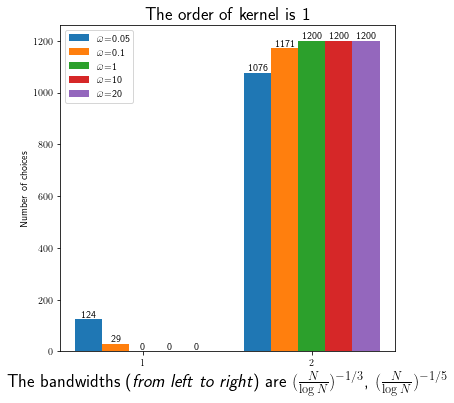

In [17]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (6,6))
bins = [0.5,1.5,2.5]

counts, edges, bars = plt.hist([oracle_choice_O1[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 1',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,3))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$

In [18]:
w_bar=23

l_regularity=1 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)



largest_num=0
no_largest=0

for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i in range(pn):
        Num_particle=N_vec[i]
        particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O1_fun, H_set_now)  
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O1)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O1, H_set_now[i+1],x_fix)  
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)

        if determine_value!=2:  
            no_largest=no_largest+1
            print ("The number of particle is", Num_particle, "The test x point is ", x_fix)
            print ("We choose the", determine_value,"-th eta.")
        else : largest_num=largest_num+1
            
print ("Done!")
print ("The number of times the largest eta has not been chosen :", no_largest)
print ("The number of times the largest eta has been chosen :", largest_num)

Done!
The number of times the largest eta has not been chosen : 0
The number of times the largest eta has been chosen : 1200


In [19]:


plot_point_number=2000

l_regularity_plus_one=2

X_plot = np.linspace(-3,4, plot_point_number)[:, np.newaxis]

# curve_1_O1 : the number of particle == 2^5 ; order = 1
curve_1_O1=np.zeros(plot_point_number)

# curve_2_O1 : the number of particle == 2^10 ; order = 1
curve_2_O1=np.zeros(plot_point_number)

# curve_3_O1 : the number of particle == 2^15 ; order = 1
curve_3_O1=np.zeros(plot_point_number)


# compute curve_1_O1 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O1
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O1
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O1[j]=kernel_O1_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    


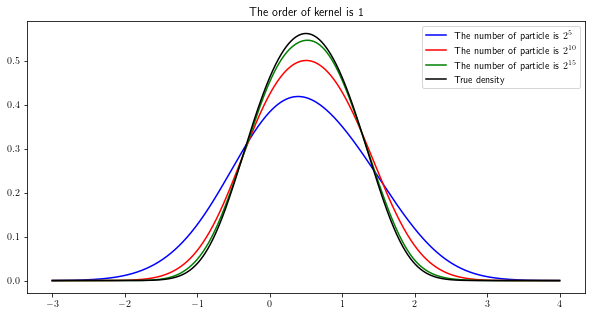

In [20]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O1,"b",label="The number of particle is $2^5$")
plt.plot(X_plot, curve_2_O1,"r",label="The number of particle is $2^{10}$")
plt.plot(X_plot, curve_3_O1,"green",label="The number of particle is $2^{15}$")

density_true_plot=density_true(X_plot)

plt.plot(X_plot, density_true_plot,"black",label="True density")

plt.title('The order of kernel is 1')

plt.legend()

### (C) -  Density simulation error (for $\bar{w}=23$)

In [23]:
error_N_Gaussian_kernel=[] # Name of the error vector !

l_regularity_plus_one=2 # regularity of kernel !

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))
        
        Error_simu_number=1000
        
        X_simu = np.linspace(-3, 4, Error_simu_number)[:, np.newaxis]
        
        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)
        
        eta_oracle = (N_vec[i]/np.log(N_vec[i]))**(-1./(2*l_regularity_plus_one+1))
        
        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O1_fun((X_simu[j]-density_particle)/eta_oracle).sum()/(N_vec[i]*eta_oracle) # O2!  
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one
        
    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_oracle, ".")
    print (i,"the error is :", error.mean())
    
    error_N_Gaussian_kernel.append(error.mean()) # Name of the error vector !

    np.savetxt("error_"+str(i)+"_op_Gaussian_kernel.csv", error_N_Gaussian_kernel, delimiter=",") # Name of the error vector !



  8%|███▋                                        | 1/12 [00:55<10:13, 55.73s/it]

i= 0 ; the number of particle is 32 ; The optimal bandwidth is 0.6411049017407774 .
0 the error is : 0.0199889710888438


 17%|███████▎                                    | 2/12 [01:50<09:11, 55.19s/it]

i= 1 ; the number of particle is 64 ; The optimal bandwidth is 0.578841083108876 .
1 the error is : 0.012649595150208142


 25%|███████████                                 | 3/12 [02:44<08:10, 54.48s/it]

i= 2 ; the number of particle is 128 ; The optimal bandwidth is 0.5196880209899403 .
2 the error is : 0.010763462087692443


 33%|██████████████▋                             | 4/12 [03:37<07:12, 54.07s/it]

i= 3 ; the number of particle is 256 ; The optimal bandwidth is 0.4646597950658026 .
3 the error is : 0.006330437898712681


 42%|██████████████████▎                         | 5/12 [04:31<06:17, 53.95s/it]

i= 4 ; the number of particle is 512 ; The optimal bandwidth is 0.41415184640113956 .
4 the error is : 0.004685106927659251


 50%|██████████████████████                      | 6/12 [05:24<05:22, 53.83s/it]

i= 5 ; the number of particle is 1024 ; The optimal bandwidth is 0.36821807300508336 .
5 the error is : 0.003000483677739406


 58%|█████████████████████████▋                  | 7/12 [06:19<04:30, 54.08s/it]

i= 6 ; the number of particle is 2048 ; The optimal bandwidth is 0.326721443196423 .
6 the error is : 0.0018376097807842134


 67%|█████████████████████████████▎              | 8/12 [07:14<03:37, 54.29s/it]

i= 7 ; the number of particle is 4096 ; The optimal bandwidth is 0.289420541554438 .
7 the error is : 0.0010327634454153235


 75%|█████████████████████████████████           | 9/12 [08:09<02:44, 54.69s/it]

i= 8 ; the number of particle is 8192 ; The optimal bandwidth is 0.2560211086904283 .
8 the error is : 0.0006614771411492606


 83%|███████████████████████████████████▊       | 10/12 [09:07<01:51, 55.62s/it]

i= 9 ; the number of particle is 16384 ; The optimal bandwidth is 0.22620734970552026 .
9 the error is : 0.0003908265702326058


 92%|███████████████████████████████████████▍   | 11/12 [10:09<00:57, 57.50s/it]

i= 10 ; the number of particle is 32768 ; The optimal bandwidth is 0.1996610529094131 .
10 the error is : 0.00022913765307422328


100%|███████████████████████████████████████████| 12/12 [11:21<00:00, 56.76s/it]

i= 11 ; the number of particle is 65536 ; The optimal bandwidth is 0.1760731372931409 .
11 the error is : 0.0001270333443636201


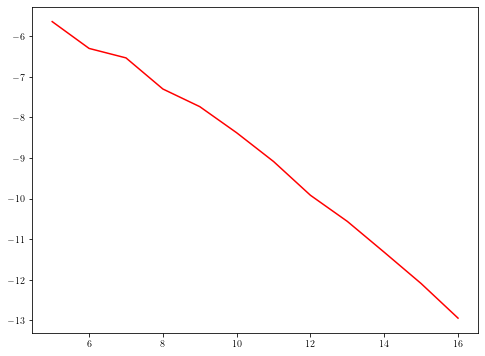

In [24]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_Gaussian_kernel),"r")


In [25]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_Gaussian_kernel)
reg_Gaussian = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Gaussian.coef_)
print ("The estimate of the intercept is", reg_Gaussian.intercept_)

The estimate of the slope is [-0.66218902]
The estimate of the intercept is -2.033126714549063


## 2.4 Kernel order = 3 <a class="anchor" id="section2-4"></a> 



### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-3,4]$. 

In [26]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=3 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)


oracle_choice_O3=np.zeros([num_w_bar,test_num_x*pn])


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
    #    print ("The test x point is ", x_fix)
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
    #        print ("The number of particle is", Num_particle)
            particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O3_fun, H_set_now)   
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O3)    
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O3, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O3[num,i_par*100+j]=determine_value

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [00:33<00:00,  6.72s/it]

Done!


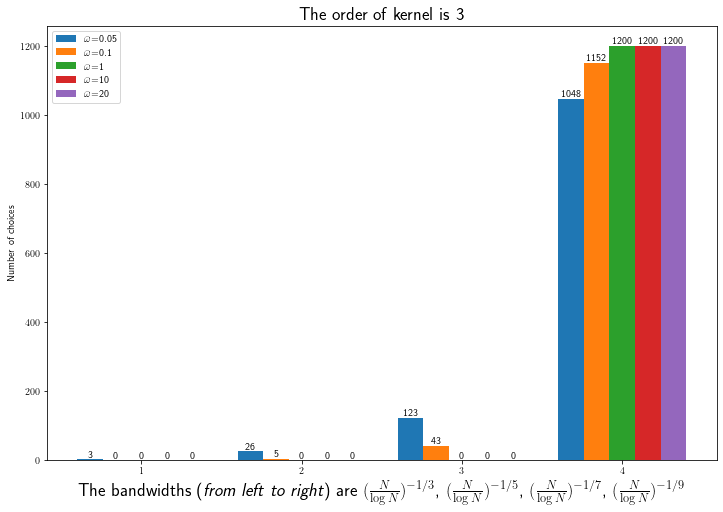

In [27]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (12,8))
bins = [0.5,1.5,2.5,3.5,4.5]

counts, edges, bars = plt.hist([oracle_choice_O3[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 3',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,5))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$

In [28]:
w_bar=23

l_regularity=3 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)


no_four=0
four_num=0


for j in range(test_num_x):
    x_fix=np.array([XX[j]])
#    print ("The test x point is ", x_fix)
    for i in range(pn):
        Num_particle=N_vec[i]
#        print ("The number of particle is", Num_particle)
        particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O3_fun, H_set_now)   
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O3)  
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O3, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)
        
        if determine_value!=4:
            no_four=no_four+1
            print ("The number of particle is", Num_particle, "The test x point is ", x_fix)
            print ("We choose the", determine_value,"-th eta.")
        else : four_num=four_num+1
            
print ("Done!")
print ("The number of times the largest eta has not been chosen :", no_four)
print ("The number of times the largest eta has been chosen :", four_num)

Done!
The number of times the largest eta has not been chosen : 0
The number of times the largest eta has been chosen : 1200


In [29]:
# plot the simulation with 4-th order kernel 


plot_point_number=2000

l_regularity_plus_one=4

X_plot = np.linspace(-3,4, plot_point_number)[:, np.newaxis]

# curve_1_O3 : the number of particle == 2^5 ; order = 3
curve_1_O3=np.zeros(plot_point_number)

# curve_2_O3 : the number of particle == 2^10 ; order = 3
curve_2_O3=np.zeros(plot_point_number)

# curve_3_O3 : the number of particle == 2^15 ; order = 3
curve_3_O3=np.zeros(plot_point_number)


# compute curve_1_O3 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O3
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O3 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O3[j]=kernel_O3_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    


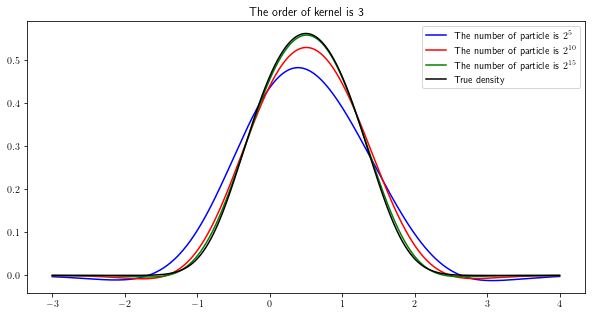

In [30]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O3,"b",label="The number of particle is $2^5$")
plt.plot(X_plot, curve_2_O3,"r",label="The number of particle is $2^{10}$")
plt.plot(X_plot, curve_3_O3,"green",label="The number of particle is $2^{15}$")

plt.plot(X_plot, density_true_plot,"black",label="True density")

plt.title('The order of kernel is 3')


plt.legend()

### (C) -  Density simulation error (for $\bar{w}=23$)

In [31]:


error_N_O3_kernel=[] 

l_regularity_plus_one=4 

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))
        
        Error_simu_number=1000
        
        X_simu = np.linspace(-3, 4, Error_simu_number)[:, np.newaxis]
        
        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)
        
        eta_oracle = (N_vec[i]/np.log(N_vec[i]))**(-1./(2*l_regularity_plus_one+1))
        
        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O3_fun((X_simu[j]-density_particle)/eta_oracle).sum()/(N_vec[i]*eta_oracle) # O4!  
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one
        
    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_oracle, ".")
    print (i,"the error is :", error.mean())
    
    error_N_O3_kernel.append(error.mean()) 

    np.savetxt("error_"+str(i)+"_op_Order_3_kernel.csv", error_N_O3_kernel, delimiter=",") 



  8%|███▋                                        | 1/12 [00:53<09:47, 53.40s/it]

i= 0 ; the number of particle is 32 ; The optimal bandwidth is 0.7811571053875341 .
0 the error is : 0.00884333395967055


 17%|███████▎                                    | 2/12 [01:46<08:55, 53.51s/it]

i= 1 ; the number of particle is 64 ; The optimal bandwidth is 0.7380546595112408 .
1 the error is : 0.004674222802837012


 25%|███████████                                 | 3/12 [02:41<08:03, 53.75s/it]

i= 2 ; the number of particle is 128 ; The optimal bandwidth is 0.6951512071563112 .
2 the error is : 0.004462254172164081


 33%|██████████████▋                             | 4/12 [03:34<07:09, 53.73s/it]

i= 3 ; the number of particle is 256 ; The optimal bandwidth is 0.6532434347145349 .
3 the error is : 0.0023971448414133413


 42%|██████████████████▎                         | 5/12 [04:28<06:16, 53.75s/it]

i= 4 ; the number of particle is 512 ; The optimal bandwidth is 0.6127889000263181 .
4 the error is : 0.0019184090366247092


 50%|██████████████████████                      | 6/12 [05:22<05:22, 53.74s/it]

i= 5 ; the number of particle is 1024 ; The optimal bandwidth is 0.574046770837112 .
5 the error is : 0.0012079617937477242


 58%|█████████████████████████▋                  | 7/12 [06:16<04:30, 54.06s/it]

i= 6 ; the number of particle is 2048 ; The optimal bandwidth is 0.5371538442699912 .
6 the error is : 0.000820176959915255


 67%|█████████████████████████████▎              | 8/12 [07:12<03:37, 54.38s/it]

i= 7 ; the number of particle is 4096 ; The optimal bandwidth is 0.5021687001225006 .
7 the error is : 0.0005174734930508888


 75%|█████████████████████████████████           | 9/12 [08:07<02:44, 54.83s/it]

i= 8 ; the number of particle is 8192 ; The optimal bandwidth is 0.46909879662609494 .
8 the error is : 0.0003300089474538784


 83%|███████████████████████████████████▊       | 10/12 [09:06<01:51, 55.89s/it]

i= 9 ; the number of particle is 16384 ; The optimal bandwidth is 0.43791781937803403 .
9 the error is : 0.00023024002994892574


 92%|███████████████████████████████████████▍   | 11/12 [10:09<00:58, 58.10s/it]

i= 10 ; the number of particle is 32768 ; The optimal bandwidth is 0.40857716178278575 .
10 the error is : 0.0001447443297824147


100%|███████████████████████████████████████████| 12/12 [11:21<00:00, 56.77s/it]

i= 11 ; the number of particle is 65536 ; The optimal bandwidth is 0.381013718253475 .
11 the error is : 7.240272843088082e-05


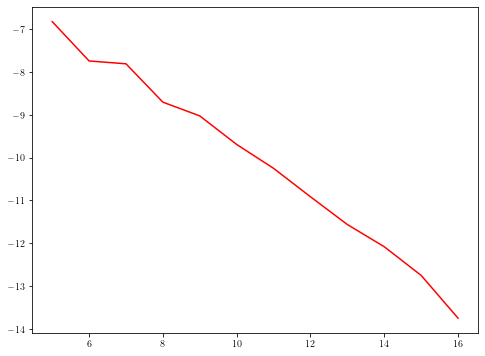

In [32]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O3_kernel),"r")


In [33]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O3_kernel)
reg_Kernal_O3 = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Kernal_O3.coef_)
print ("The estimate of the intercept is", reg_Kernal_O3.intercept_)

The estimate of the slope is [-0.60085322]
The estimate of the intercept is -3.7843246529981664


## 2.5 Kernel order = 5 <a class="anchor" id="section2-5"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-3,4]$. 

In [34]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=5 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)


oracle_choice_O5=np.zeros([num_w_bar,test_num_x*pn])


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
            particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O5_fun, H_set_now)  
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O5)   
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O5, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O5[num,i_par*100+j]=determine_value  

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [01:27<00:00, 17.57s/it]

Done!


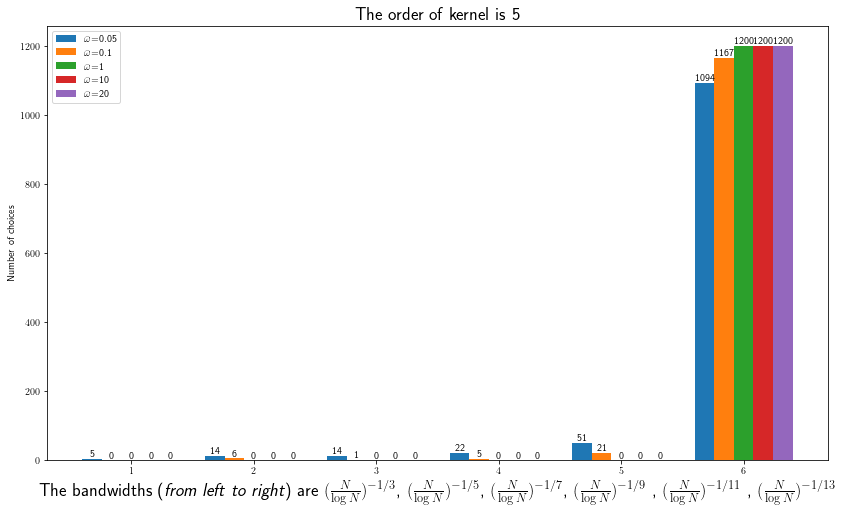

In [35]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (14,8))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5]

counts, edges, bars = plt.hist([oracle_choice_O5[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 5',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,7))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$


In [36]:
w_bar=23

l_regularity=5 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)



largest_num=0
no_largest=0

for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i in range(pn):
        Num_particle=N_vec[i]
        particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O5_fun, H_set_now)  
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O5)   
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O5, H_set_now[i+1],x_fix) 
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)

        if determine_value!=6:  
            no_largest=no_largest+1
            print ("The number of particle is", Num_particle, "The test x point is ", x_fix)
            print ("We choose the", determine_value,"-th eta.")
        else : largest_num=largest_num+1
            
print ("Done!")
print ("The number of times the largest eta has not been chosen :", no_largest)
print ("The number of times the largest eta has been chosen :", largest_num)



Done!
The number of times the largest eta has not been chosen : 0
The number of times the largest eta has been chosen : 1200


In [37]:
# plot the simulation with 6-th order kernel 


plot_point_number=2000

l_regularity_plus_one=6

X_plot = np.linspace(-3,4, plot_point_number)[:, np.newaxis]

# curve_1_O5 : the number of particle == 2^5 ; order = 5
curve_1_O5=np.zeros(plot_point_number)

# curve_2_O5 : the number of particle == 2^10 ; order = 5
curve_2_O5=np.zeros(plot_point_number)

# curve_3_O5 : the number of particle == 2^15 ; order = 5
curve_3_O5=np.zeros(plot_point_number)


# compute curve_1_O5 
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O5 
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O5 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O5[j]=kernel_O5_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

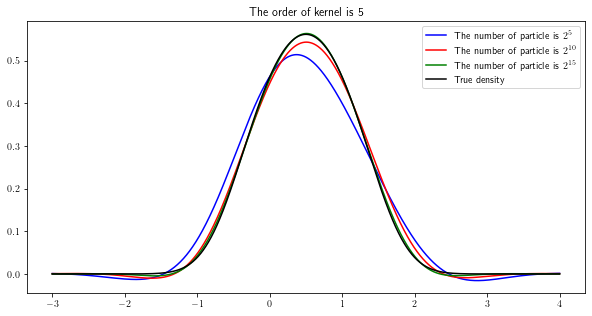

In [38]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O5,"b",label="The number of particle is $2^5$")
plt.plot(X_plot, curve_2_O5,"r",label="The number of particle is $2^{10}$")
plt.plot(X_plot, curve_3_O5,"green",label="The number of particle is $2^{15}$")
plt.plot(X_plot, density_true_plot,"black",label="True density")

plt.title('The order of kernel is 5')

plt.legend()



### (C) -  Density simulation error (for $\bar{w}=23$)


In [39]:


error_N_O5_kernel=[] 

l_regularity_plus_one=6 # regularity of kernel !

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))
        
        Error_simu_number=1000
        
        X_simu = np.linspace(-3, 4, Error_simu_number)[:, np.newaxis]
        
        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)
        
        eta_oracle = (N_vec[i]/np.log(N_vec[i]))**(-1./(2*l_regularity_plus_one+1))
        
        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O5_fun((X_simu[j]-density_particle)/eta_oracle).sum()/(N_vec[i]*eta_oracle) # O6!  
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one
        
    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_oracle, ".")
    print (i,"the error is :", error.mean())
    
    error_N_O5_kernel.append(error.mean()) # Name of the error vector !

    np.savetxt("error_"+str(i)+"_op_Order_5_kernel.csv", error_N_O5_kernel, delimiter=",") # Name of the error vector !



  8%|███▋                                        | 1/12 [00:53<09:53, 53.97s/it]

i= 0 ; the number of particle is 32 ; The optimal bandwidth is 0.8428338326633098 .
0 the error is : 0.006927218816190414


 17%|███████▎                                    | 2/12 [01:47<08:59, 53.94s/it]

i= 1 ; the number of particle is 64 ; The optimal bandwidth is 0.8103575301625457 .
1 the error is : 0.0032009602529088762


 25%|███████████                                 | 3/12 [02:41<08:03, 53.75s/it]

i= 2 ; the number of particle is 128 ; The optimal bandwidth is 0.7774460684077394 .
2 the error is : 0.003059769544227425


 33%|██████████████▋                             | 4/12 [03:35<07:10, 53.79s/it]

i= 3 ; the number of particle is 256 ; The optimal bandwidth is 0.744689168593168 .
3 the error is : 0.0013582477273347431


 42%|██████████████████▎                         | 5/12 [04:29<06:17, 53.89s/it]

i= 4 ; the number of particle is 512 ; The optimal bandwidth is 0.7124488553315885 .
4 the error is : 0.0011759423096939542


 50%|██████████████████████                      | 6/12 [05:23<05:24, 54.12s/it]

i= 5 ; the number of particle is 1024 ; The optimal bandwidth is 0.6809533276214842 .
5 the error is : 0.0007099859871572285


 58%|█████████████████████████▋                  | 7/12 [06:19<04:32, 54.49s/it]

i= 6 ; the number of particle is 2048 ; The optimal bandwidth is 0.6503471564358044 .
6 the error is : 0.0004662037552975592


 67%|█████████████████████████████▎              | 8/12 [07:16<03:41, 55.36s/it]

i= 7 ; the number of particle is 4096 ; The optimal bandwidth is 0.6207202368114458 .
7 the error is : 0.00029418812643127156


 75%|█████████████████████████████████           | 9/12 [08:17<02:51, 57.16s/it]

i= 8 ; the number of particle is 8192 ; The optimal bandwidth is 0.5921254928393913 .
8 the error is : 0.00019040874931949


 83%|███████████████████████████████████▊       | 10/12 [09:26<02:01, 60.71s/it]

i= 9 ; the number of particle is 16384 ; The optimal bandwidth is 0.5645902195758109 .
9 the error is : 0.00013707021715708606


 92%|███████████████████████████████████████▍   | 11/12 [10:49<01:07, 67.55s/it]

i= 10 ; the number of particle is 32768 ; The optimal bandwidth is 0.5381236266042277 .
10 the error is : 9.98452472764444e-05


100%|███████████████████████████████████████████| 12/12 [12:46<00:00, 63.87s/it]

i= 11 ; the number of particle is 65536 ; The optimal bandwidth is 0.5127220116773975 .
11 the error is : 5.452624806443139e-05


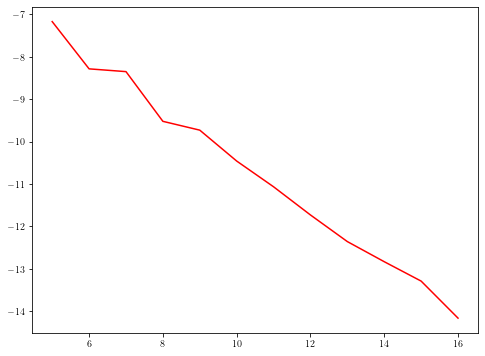

In [40]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O5_kernel),"r")


In [41]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O5_kernel)
reg_Kernal_O5 = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Kernal_O5.coef_)
print ("The estimate of the intercept is", reg_Kernal_O5.intercept_)

The estimate of the slope is [-0.60854817]
The estimate of the intercept is -4.357814740602039


## 2.6 Kernel order = 7 <a class="anchor" id="section2-6"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-3,4]$. 


In [42]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=7                     

test_num_x=100
XX=np.linspace(-3,4,test_num_x)


oracle_choice_O7=np.zeros([num_w_bar,test_num_x*pn])  


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
            particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O7_fun, H_set_now)  
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O7)   
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O7, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O7[num,i_par*100+j]=determine_value  

            
print ("Done!")

100%|█████████████████████████████████████████████| 5/5 [03:41<00:00, 44.37s/it]

Done!


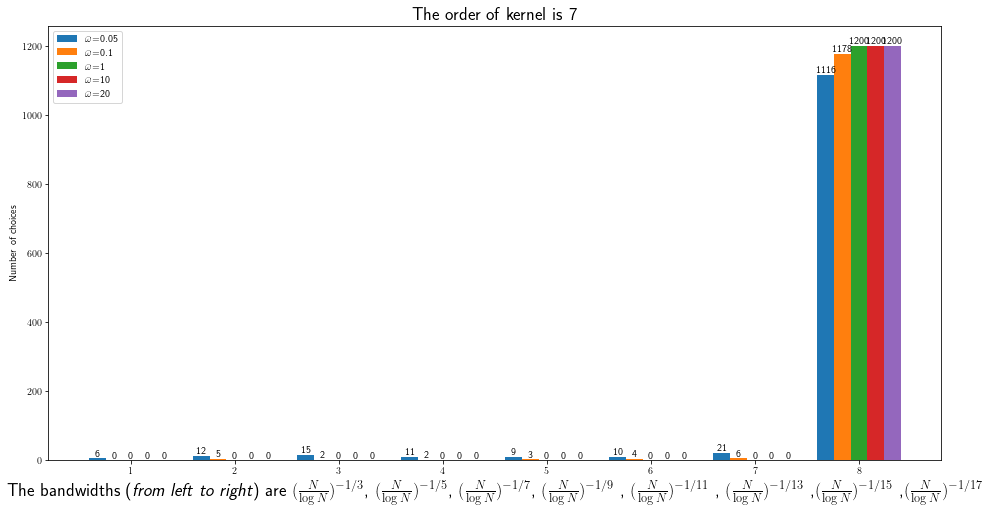

In [43]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (16,8))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

counts, edges, bars = plt.hist([oracle_choice_O7[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 7',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,9))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

#plt.savefig('burgers_distribution_order7.png')

plt.show()

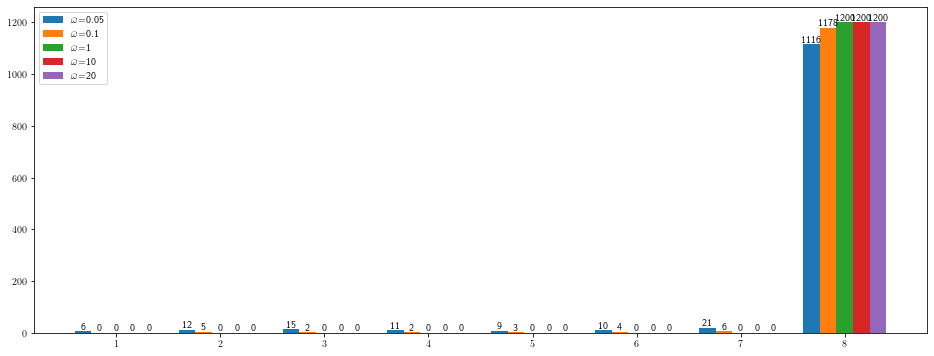

In [64]:
# Figure 11 of the paper

plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (16,6))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

counts, edges, bars = plt.hist([oracle_choice_O7[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

#plt.title('The order of kernel is 7',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,9))
plt.legend(loc='upper left')
#plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$',fontsize=18, color='black')
#plt.ylabel("Number of choices")

plt.savefig('burgers_distribution_order7.png')

plt.show()



### (B) -  Simulated density function for $\bar{w}=23$

In [45]:
w_bar=23

l_regularity=7 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)



largest_num=0
no_largest=0

for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i in range(pn):
        Num_particle=N_vec[i]
        particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O7_fun, H_set_now)  
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O7)    
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O7, H_set_now[i+1],x_fix)  
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)

        if determine_value!=8: 
            no_largest=no_largest+1
            print ("The number of particle is", Num_particle, "The test x point is ", x_fix)
            print ("We choose the", determine_value,"-th eta.")
        else : largest_num=largest_num+1
            
print ("Done!")
print ("The number of times the largest eta has not been chosen :", no_largest)
print ("The number of times the largest eta has been chosen :", largest_num)


Done!
The number of times the largest eta has not been chosen : 0
The number of times the largest eta has been chosen : 1200


In [46]:
# plot the simulation with 8-th order kernel 


plot_point_number=2000

l_regularity_plus_one=8

X_plot = np.linspace(-3,4, plot_point_number)[:, np.newaxis]

# curve_1_O7 : the number of particle == 2^5 ; order = 7
curve_1_O7=np.zeros(plot_point_number)

# curve_2_O7 : the number of particle == 2^10 ; order = 7
curve_2_O7=np.zeros(plot_point_number)

# curve_3_O7 : the number of particle == 2^15 ; order = 7
curve_3_O7=np.zeros(plot_point_number)


# compute curve_1_O7
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O7 
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O7 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O7[j]=kernel_O7_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

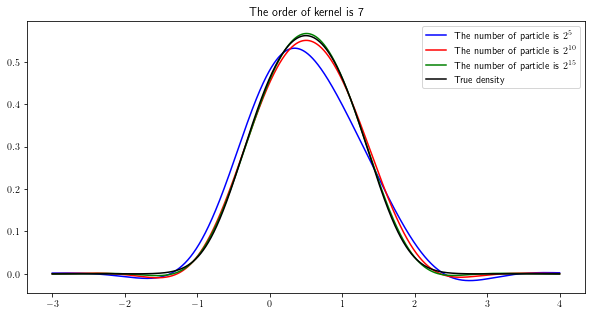

In [47]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O7,"b",label="The number of particle is $2^5$")
plt.plot(X_plot, curve_2_O7,"r",label="The number of particle is $2^{10}$")
plt.plot(X_plot, curve_3_O7,"green",label="The number of particle is $2^{15}$")

plt.plot(X_plot, density_true_plot,"black",label="True density")

plt.title('The order of kernel is 7')

plt.legend()

### (C) -  Density simulation error (for $\bar{w}=23$)




In [48]:


error_N_O7_kernel=[] # Name of the error vector !

l_regularity_plus_one=8 # regularity of kernel !

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))
        
        Error_simu_number=1000
        
        X_simu = np.linspace(-3, 4, Error_simu_number)[:, np.newaxis]
        
        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)
        
        eta_oracle = (N_vec[i]/np.log(N_vec[i]))**(-1./(2*l_regularity_plus_one+1))
        
        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O7_fun((X_simu[j]-density_particle)/eta_oracle).sum()/(N_vec[i]*eta_oracle) 
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one
        
    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_oracle, ".")
    print (i,"the error is :", error.mean())
    
    error_N_O7_kernel.append(error.mean()) # Name of the error vector !

    np.savetxt("error_"+str(i)+"_op_Order_7_kernel.csv", error_N_O7_kernel, delimiter=",") 



  8%|███▋                                        | 1/12 [00:54<09:58, 54.45s/it]

i= 0 ; the number of particle is 32 ; The optimal bandwidth is 0.8774339624011824 .
0 the error is : 0.007241020715447758


 17%|███████▎                                    | 2/12 [01:49<09:07, 54.74s/it]

i= 1 ; the number of particle is 64 ; The optimal bandwidth is 0.8514605166719212 .
1 the error is : 0.003279901275139474


 25%|███████████                                 | 3/12 [02:43<08:12, 54.68s/it]

i= 2 ; the number of particle is 128 ; The optimal bandwidth is 0.82488786292395 .
2 the error is : 0.002877221676726111


 33%|██████████████▋                             | 4/12 [03:39<07:21, 55.15s/it]

i= 3 ; the number of particle is 256 ; The optimal bandwidth is 0.7981758029274854 .
3 the error is : 0.0011048010128499042


 42%|██████████████████▎                         | 5/12 [04:34<06:25, 55.08s/it]

i= 4 ; the number of particle is 512 ; The optimal bandwidth is 0.7716136164488763 .
4 the error is : 0.0009905899426424472


 50%|██████████████████████                      | 6/12 [05:30<05:30, 55.14s/it]

i= 5 ; the number of particle is 1024 ; The optimal bandwidth is 0.7453904997069756 .
5 the error is : 0.0005721049266621737


 58%|█████████████████████████▋                  | 7/12 [06:27<04:38, 55.72s/it]

i= 6 ; the number of particle is 2048 ; The optimal bandwidth is 0.7196329996424173 .
6 the error is : 0.0003107948501466766


 67%|█████████████████████████████▎              | 8/12 [07:26<03:47, 56.97s/it]

i= 7 ; the number of particle is 4096 ; The optimal bandwidth is 0.6944264909788707 .
7 the error is : 0.00022357818784387966


 75%|█████████████████████████████████           | 9/12 [08:32<02:59, 59.83s/it]

i= 8 ; the number of particle is 8192 ; The optimal bandwidth is 0.6698282545792238 .
8 the error is : 0.00014591696171408844


 83%|███████████████████████████████████▊       | 10/12 [09:50<02:10, 65.49s/it]

i= 9 ; the number of particle is 16384 ; The optimal bandwidth is 0.6458758301993592 .
9 the error is : 0.00010087148469728294


 92%|███████████████████████████████████████▍   | 11/12 [11:33<01:16, 76.86s/it]

i= 10 ; the number of particle is 32768 ; The optimal bandwidth is 0.6225925628563277 .
10 the error is : 9.18107878126169e-05


100%|███████████████████████████████████████████| 12/12 [14:08<00:00, 70.74s/it]

i= 11 ; the number of particle is 65536 ; The optimal bandwidth is 0.5999914065340403 .
11 the error is : 7.06248483120188e-05


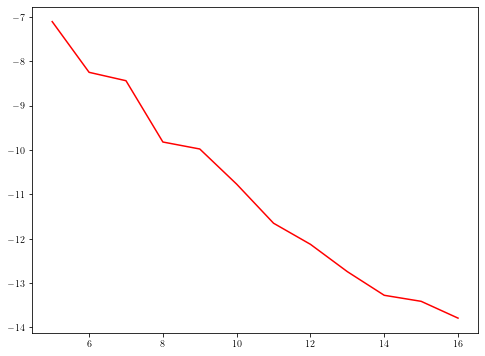

In [49]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O7_kernel),"r")


In [50]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O7_kernel)
reg_Kernal_O7 = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Kernal_O7.coef_)
print ("The estimate of the intercept is", reg_Kernal_O7.intercept_)

The estimate of the slope is [-0.61423948]
The estimate of the intercept is -4.498199485392443


## 2.7 Kernel order = 9 <a class="anchor" id="section2-7"></a> 

### (A) -  Distrubtion of optimal bandwidths 

In the following two cells, we test for 100 values of $x$ in $[-3,4]$. 


In [51]:
w_bar_values=[0.05,0.1,1,10,20]

num_w_bar=len(w_bar_values)

l_regularity=9                   

test_num_x=100
XX=np.linspace(-3,4,test_num_x)


oracle_choice_O9=np.zeros([num_w_bar,test_num_x*pn]) 


for num in tqdm(range(num_w_bar)):
    w_bar=w_bar_values[num]
    for j in range(test_num_x):
        x_fix=np.array([XX[j]])
        for i_par in range(pn):
            Num_particle=N_vec[i_par]
            particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
            H_set_now=H_set_func(Num_particle, l_regularity+1)
        
            KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O9_fun, H_set_now)  
        
            V_vector=np.zeros([H_set_now.size])
            A_vector=np.zeros([H_set_now.size])
            for i in range(H_set_now.size):
                V_vector=V_value(H_set_now, Num_particle, normL2_O9)   
            for i in range(H_set_now.size-1):
                A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O9, H_set_now[i+1],x_fix)
        
            determine_value=determine_fun(V_vector, A_vector, H_set_now)
            oracle_choice_O9[num,i_par*100+j]=determine_value 

            
print ("Done!")


100%|█████████████████████████████████████████████| 5/5 [07:44<00:00, 92.84s/it]

Done!


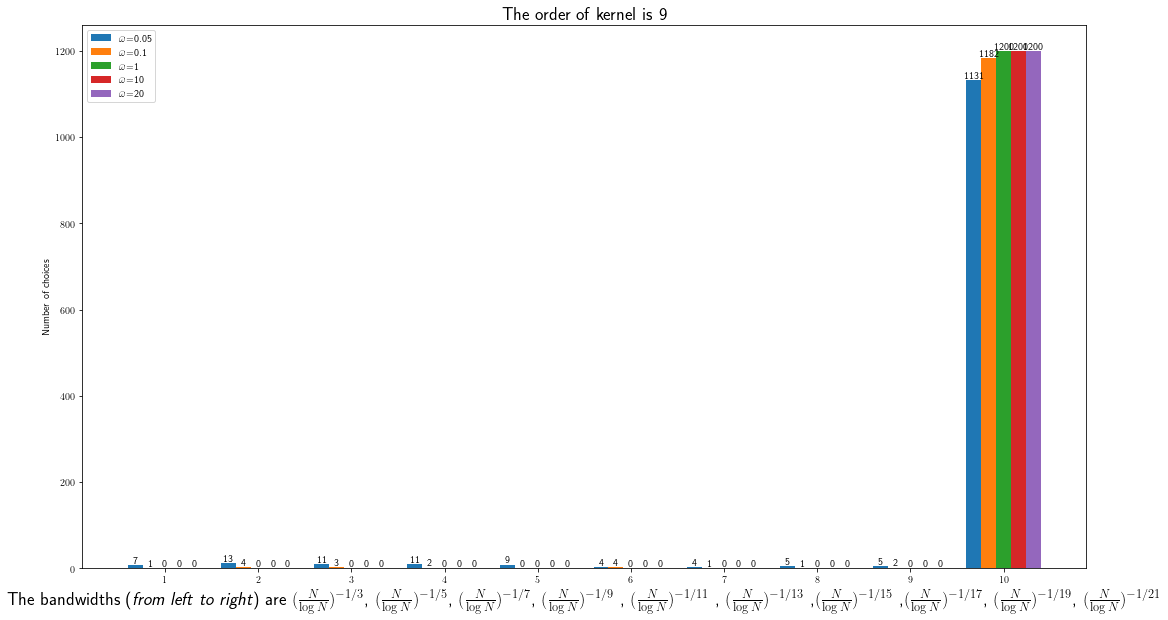

In [52]:
plt.rcParams['text.usetex'] = True

fig, ax = plt.subplots(figsize = (18,10))
bins = [0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5]

counts, edges, bars = plt.hist([oracle_choice_O9[i,:] for i in range(num_w_bar)],bins,label=[r'$\bar{\omega}$=0.05',r'$\bar{\omega}$=0.1',r'$\bar{\omega}$=1',r'$\bar{\omega}$=10',r'$\bar{\omega}$=20'])

plt.title('The order of kernel is 9',fontsize=18, color='black')
for b in bars:
    ax.bar_label(b)

plt.xticks(range(1,11))
plt.legend(loc='upper left')
plt.xlabel(r'The bandwidths (\textit{from left to right}) are $(\frac{N}{\log N})^{-1/3}$, $(\frac{N}{\log N})^{-1/5}$, $(\frac{N}{\log N})^{-1/7}$, $(\frac{N}{\log N})^{-1/9}$ , $(\frac{N}{\log N})^{-1/11}$ , $(\frac{N}{\log N})^{-1/13}$ ,$(\frac{N}{\log N})^{-1/15}$ ,$(\frac{N}{\log N})^{-1/17}$, $(\frac{N}{\log N})^{-1/19}$, $(\frac{N}{\log N})^{-1/21}$',fontsize=18, color='black')
plt.ylabel("Number of choices")

plt.show()

### (B) -  Simulated density function for $\bar{w}=23$

In [53]:
w_bar=23

l_regularity=9 

test_num_x=100
XX=np.linspace(-3,4,test_num_x)



largest_num=0
no_largest=0

for j in range(test_num_x):
    x_fix=np.array([XX[j]])
    for i in range(pn):
        Num_particle=N_vec[i]
        particle_now = np.array(pd.read_csv("burger_eq_particle_number_"+str(Num_particle)+".csv", sep=',',header=None))
        
        H_set_now=H_set_func(Num_particle, l_regularity+1)
        
        KDE_s_now=KDE_fun_s(Num_particle, particle_now, kernel_O9_fun, H_set_now)  
        
        V_vector=np.zeros([H_set_now.size])
        A_vector=np.zeros([H_set_now.size])
        for i in range(H_set_now.size):
            V_vector=V_value(H_set_now, Num_particle, normL2_O9)   
        for i in range(H_set_now.size-1):
            A_vector[i+1]=A_value(Num_particle,KDE_s_now,H_set_now, normL2_O9, H_set_now[i+1],x_fix)
        
        determine_value=determine_fun(V_vector, A_vector, H_set_now)

        if determine_value!=10:  # Order 10 here !!!! 
            no_largest=no_largest+1
            print ("The number of particle is", Num_particle, "The test x point is ", x_fix)
            print ("We choose the", determine_value,"-th eta.")
        else : largest_num=largest_num+1
            
print ("Done!")
print ("The number of times the largest eta has not been chosen :", no_largest)
print ("The number of times the largest eta has been chosen :", largest_num)

Done!
The number of times the largest eta has not been chosen : 0
The number of times the largest eta has been chosen : 1200


In [54]:
# plot the simulation with 6-th order kernel 


plot_point_number=2000

l_regularity_plus_one=10

X_plot = np.linspace(-3,4, plot_point_number)[:, np.newaxis]

# curve_1_O9 : the number of particle == 2^5 ; order = 9
curve_1_O9=np.zeros(plot_point_number)

# curve_2_O9 : the number of particle == 2^10 ; order = 9
curve_2_O9=np.zeros(plot_point_number)

# curve_3_O9 : the number of particle == 2^15 ; order = 9
curve_3_O9=np.zeros(plot_point_number)


# compute curve_1_O9
particle_num_plot=2**5
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_1_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)    

    
# compute curve_2_O9
particle_num_plot=2**10
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_2_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
# compute curve_3_O9 
particle_num_plot=2**15
eta_oracle = (particle_num_plot/np.log(particle_num_plot))**(-1./(2*l_regularity_plus_one+1))
density_particle_plot=np.array(pd.read_csv("burger_eq_particle_number_"+str(particle_num_plot)+".csv", sep=',',header=None))

for j in range(plot_point_number):
    curve_3_O9[j]=kernel_O9_fun((X_plot[j]-density_particle_plot)/eta_oracle).sum()/(particle_num_plot*eta_oracle)   
    
    

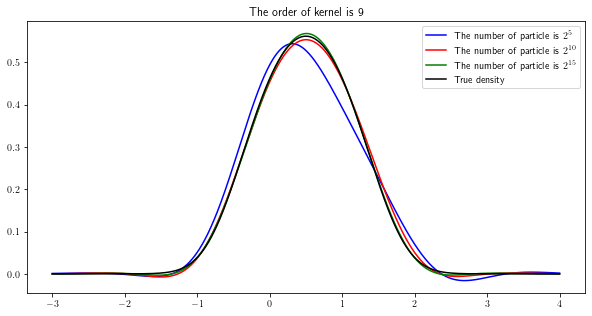

In [55]:
plt.figure(figsize = (10,5))
plt.plot(X_plot, curve_1_O9,"b",label="The number of particle is $2^5$")
plt.plot(X_plot, curve_2_O9,"r",label="The number of particle is $2^{10}$")
plt.plot(X_plot, curve_3_O9,"green",label="The number of particle is $2^{15}$")

plt.plot(X_plot, density_true_plot,"black",label="True density")

plt.title('The order of kernel is 9')

plt.legend()

----------------------

**Now we compute the density simulation error of Gaussian higher order kernel (order 10).**

In the next code cell, we computer the density simulation error as follows :

- (1) For every particle number $N\in\{128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768\}$, for every particle system $j\in\{1, ..., 30\}$, we simulated a density function by using Gaussian higher order kernel (order 10) with the oracle optimal bandwidth $(\frac{N}{\log(N)})^{-\frac{1}{21}}$. Let $f^{N,j}_{\text{simu}}$ denote the simulated density function and let $f_{\text{true}}$ denote the true density function. 


- (2) We take 1000 points $x\in[-3,4]$. The simulation error is computed by 
$$ \text{Error}_N=\frac{1}{30}\sum_{j=1}^{30}\max_{x\in[-3,4]}\big| \,f^{N,j}_{\text{simu}}(x)- f_{\text{true}}(x)\,\big|^{2}$$
for every particle number $N\in\{128, 256, 512, 1024, 2048, 4096, 8192, 16384, 32768\}$.


In [56]:
error_N_O9_kernel=[] 

l_regularity_plus_one=10

for i in tqdm(range(pn)):
    error=np.zeros(NNs)
    for nns in range(NNs):

        density_particle= np.array(pd.read_csv("burger_eq_part_number_"+str(N_vec[i])+"repeat"+str(nns)+".csv", sep=',',header=None))
        
        Error_simu_number=1000
        
        X_simu = np.linspace(-3, 4, Error_simu_number)[:, np.newaxis]
        
        Error_simu_vec=np.zeros(Error_simu_number)
        error_vec=np.zeros(Error_simu_number)
        
        eta_oracle = (N_vec[i]/np.log(N_vec[i]))**(-1./(2*l_regularity_plus_one+1))
        
        for j in range(Error_simu_number):
            Error_simu_vec[j]=kernel_O9_fun((X_simu[j]-density_particle)/eta_oracle).sum()/(N_vec[i]*eta_oracle) ##O8!  
            error_vec[j]=np.abs(Error_simu_vec[j] - density_true(X_simu[j]))

        error_one=error_vec.max()**2
        error[nns]=error_one
        
    print ("i=",i,";", "the number of particle is", N_vec[i],";", "The optimal bandwidth is",eta_oracle, ".")
    print (i,"the error is :", error.mean())
    
    error_N_O9_kernel.append(error.mean()) # Name of the error vector !

    np.savetxt("error_"+str(i)+"_op_Order_9_kernel.csv", error_N_O9_kernel, delimiter=",") 


  8%|███▋                                        | 1/12 [00:54<09:57, 54.28s/it]

i= 0 ; the number of particle is 32 ; The optimal bandwidth is 0.8995612463190376 .
0 the error is : 0.008676499377569103


 17%|███████▎                                    | 2/12 [01:50<09:13, 55.32s/it]

i= 1 ; the number of particle is 64 ; The optimal bandwidth is 0.8779433857753511 .
1 the error is : 0.004017531359975465


 25%|███████████                                 | 3/12 [02:45<08:17, 55.31s/it]

i= 2 ; the number of particle is 128 ; The optimal bandwidth is 0.8556963745809647 .
2 the error is : 0.0031867338589783457


 33%|██████████████▋                             | 4/12 [03:40<07:19, 54.98s/it]

i= 3 ; the number of particle is 256 ; The optimal bandwidth is 0.833194609535621 .
3 the error is : 0.0012488224496219678


 42%|██████████████████▎                         | 5/12 [04:34<06:23, 54.82s/it]

i= 4 ; the number of particle is 512 ; The optimal bandwidth is 0.8106763888404129 .
4 the error is : 0.0010459427469582511


 50%|██████████████████████                      | 6/12 [05:31<05:33, 55.54s/it]

i= 5 ; the number of particle is 1024 ; The optimal bandwidth is 0.7883002979044331 .
5 the error is : 0.0006162309452055287


 58%|█████████████████████████▋                  | 7/12 [06:29<04:42, 56.41s/it]

i= 6 ; the number of particle is 2048 ; The optimal bandwidth is 0.7661750568410738 .
6 the error is : 0.0002829531556959708


 67%|█████████████████████████████▎              | 8/12 [07:31<03:52, 58.12s/it]

i= 7 ; the number of particle is 4096 ; The optimal bandwidth is 0.744376583705968 .
7 the error is : 0.00024404656105525587


 75%|█████████████████████████████████           | 9/12 [08:42<03:06, 62.15s/it]

i= 8 ; the number of particle is 8192 ; The optimal bandwidth is 0.7229583523676978 .
8 the error is : 0.00015749753129606594


 83%|███████████████████████████████████▊       | 10/12 [10:11<02:21, 70.55s/it]

i= 9 ; the number of particle is 16384 ; The optimal bandwidth is 0.7019579900763208 .
9 the error is : 0.00011267220217608668


 92%|███████████████████████████████████████▍   | 11/12 [12:16<01:27, 87.04s/it]

i= 10 ; the number of particle is 32768 ; The optimal bandwidth is 0.6814016490218607 .
10 the error is : 0.00010581858150485243


100%|███████████████████████████████████████████| 12/12 [15:28<00:00, 77.38s/it]

i= 11 ; the number of particle is 65536 ; The optimal bandwidth is 0.661306999835539 .
11 the error is : 8.864222726253064e-05


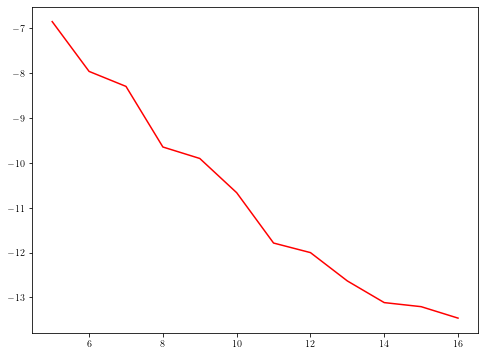

In [57]:
plt.figure(figsize=(8,6))

plt.plot(np.log2(N_vec),np.log2(error_N_O9_kernel),"r")


In [58]:
X=np.log2(N_vec).reshape(-1,1)
y=np.log2(error_N_O9_kernel)
reg_Kernal_O9 = LinearRegression().fit(X, y)
print ("The estimate of the slope is", reg_Kernal_O9.coef_)
print ("The estimate of the intercept is", reg_Kernal_O9.intercept_)

The estimate of the slope is [-0.61564029]
The estimate of the intercept is -4.328754007968096


## 2.8 Comparison of simulated densities with different kernels <a class="anchor" id="section2-8"></a> 



The next cell compares the simulated densities with different kernels for $2^5$ particles. 


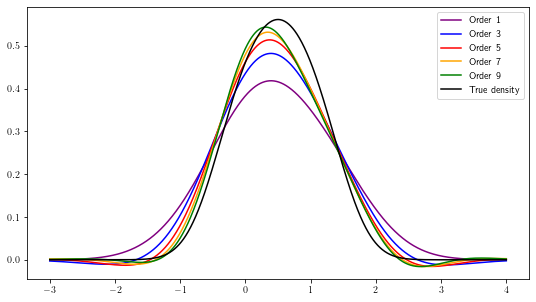

In [59]:
plt.figure(figsize = (9,5))
plt.plot(X_plot, curve_1_O1,"purple",label="Order 1")

plt.plot(X_plot, curve_1_O3,"b",label="Order 3")
plt.plot(X_plot, curve_1_O5,"r",label="Order 5")
plt.plot(X_plot, curve_1_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_1_O9,"green",label="Order 9")


plt.plot(X_plot, density_true_plot,"black",label="True density")
plt.legend()
#plt.title('The number of particle is $2^5$')
plt.savefig('burgers_density_simu_particle6.png')




The next cell compares the simulated densities with different kernels for $2^{10}$ particles. 


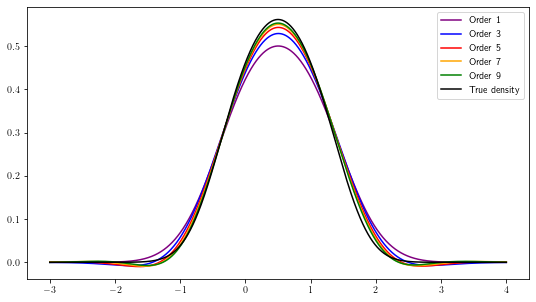

In [60]:
plt.figure(figsize = (9,5))
plt.plot(X_plot, curve_2_O1,"purple",label="Order 1")

plt.plot(X_plot, curve_2_O3,"b",label="Order 3")
plt.plot(X_plot, curve_2_O5,"r",label="Order 5")
plt.plot(X_plot, curve_2_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_2_O9,"green",label="Order 9")


plt.plot(X_plot, density_true_plot,"black",label="True density")
plt.legend()
#plt.title('The number of particle is $2^{10}$')
plt.savefig('burgers_density_simu_particle10.png')




The next cell compares the simulated densities with different kernels for $2^{15}$ particles. 

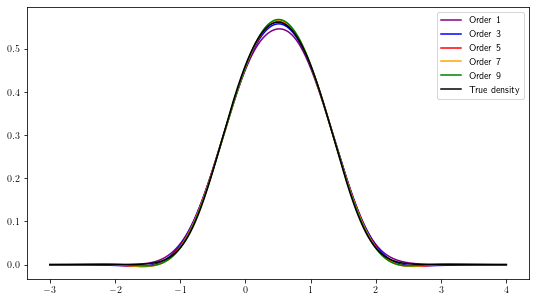

In [61]:
plt.figure(figsize = (9,5))
plt.plot(X_plot, curve_3_O1,"purple",label="Order 1")

plt.plot(X_plot, curve_3_O3,"b",label="Order 3")
plt.plot(X_plot, curve_3_O5,"r",label="Order 5")
plt.plot(X_plot, curve_3_O7,"orange",label="Order 7")
plt.plot(X_plot, curve_3_O9,"green",label="Order 9")


plt.plot(X_plot, density_true_plot,"black",label="True density")
plt.legend()
#plt.title('The number of particle is $2^{15}$')
plt.savefig('burgers_density_simu_particle15.png')




-----------------------

### Error Comparison for different order kernel 

The next cell shows the log-log error curves of the density simulation with different Gaussian high order kernels for $l=1$ (purple), $l=3$ (blue), $l=5$ (red), $l=7$ (orange), $l=9$ (green). 

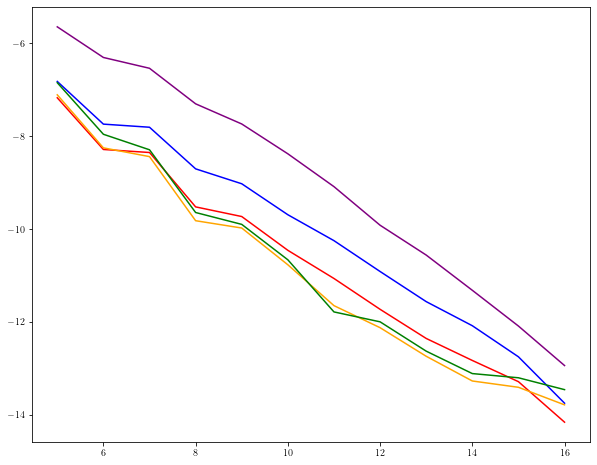

In [62]:

plt.figure(figsize = (10,8))
plt.plot(np.log2(N_vec), np.log2(error_N_Gaussian_kernel),"purple") # ,label="Order 1"
plt.plot(np.log2(N_vec), np.log2(error_N_O3_kernel),"b") # ,label="Order 3"
plt.plot(np.log2(N_vec), np.log2(error_N_O5_kernel),"r") # ,label="Order 5"
plt.plot(np.log2(N_vec), np.log2(error_N_O7_kernel),"orange") # ,label="Order 7"
plt.plot(np.log2(N_vec), np.log2(error_N_O9_kernel),"green") # ,label="Order 9"
plt.savefig('strong_error_burgers.png')
#plt.legend()

The next cell shows the slopes $a_l$ of the above figure as a function of the kernal order $l$. 

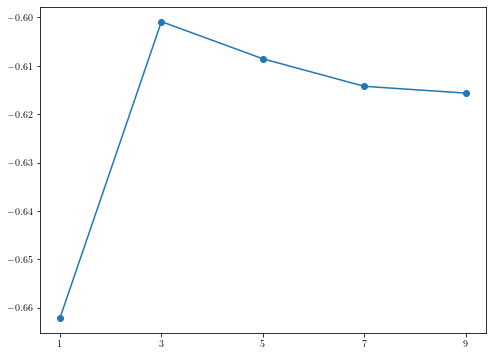

In [63]:
slope_vec=np.array([reg_Gaussian.coef_,reg_Kernal_O3.coef_,reg_Kernal_O5.coef_,reg_Kernal_O7.coef_,reg_Kernal_O9.coef_])

plt.figure(figsize = (8,6))
plt.plot(np.array([1,3,5,7,9]),slope_vec,"o-")
plt.xticks([1,3,5,7,9])
plt.savefig('strong_error_slope_burgers.png')
